# Measuring speedup over baseline kernels

NPUEval comes with 102 canonical unoptimized kernels along with the prompts. These are useful for setting the baseline floor of performance. They also give us a concrete cycle count values which ultimately we want to minimize. In this notebook we will learn how to plot and interpret the relative speedup values of the test kernels.

Before running this notebook make sure you have ran the `run_canonical.py` script located in the scripts/ dir of this repository. This ensures that the baseline evaluations are available.

## Goals

* Generate speedup plots using previously generated results + canonical solutions

## Imports and setup

Like in previous notebooks we'll only use two models and a small subset of the dataset for illustration purposes.

In [1]:
import os
import json
import pandas as pd
import math
import matplotlib.pyplot as plt

from npueval import dataset

models = [
    "gpt-4.1", 
    "gpt-4o-mini",
]

tests = dataset[:5]

## Parse results

We'll iterate over the same 5 kernels that were generated in the previous notebooks. You can adapt this snippet to point to your own evaluations directory and model list.

In [2]:
# We'll keep a list of results per model config
results = []

# Calculate stats for each model (including pass rate, vectorization score and speedup)
for model in models:
    print(model)

    # Solutions path of previously run model evaluations
    solutions_path = f"results/evaluations/{model}/"

    # Canonical kernel evaluations (make sure to run before this notebook)
    canonical_path = "../results/evaluations/canonical/"

    # Initialize totals at 0
    num_passes, total_score, total_speedup = 0, 0, 0

    # For each kernel
    for test in tests:
        eval_path = os.path.join(solutions_path, f"{test['kernel_name']}_wrapper.json")
        baseline_path = os.path.join(canonical_path, f"{test['kernel_name']}_wrapper.json")

        # Load test results
        with open(eval_path, 'r') as eval_f:
            eval_data = json.load(eval_f)

            # If functional test passed get runtime stats
            if eval_data.get('result') == "Pass":
                total_cycles = eval_data.get('total_cycles')
                total_score += eval_data.get('vector_score', 0)
                
                # Count number of passed tests
                num_passes += 1

                # Load baseline results
                with open(baseline_path, 'r') as baseline_f:
                    baseline_data = json.load(baseline_f)
                    baseline_cycles = baseline_data.get('total_cycles')
                    
                    # Calculate relative speedup over baseline
                    speedup = baseline_cycles / total_cycles

                    # Safeguard against NaN
                    if not math.isnan(speedup):
                        total_speedup += speedup

    # Compute average based on total test set
    pass_rate = num_passes / len(tests)
    avg_score = total_score / len(tests)
    avg_speedup = total_speedup / len(tests)

    results.append({
        "model": model,
        "avg_score": avg_score,
        "pass_rate": pass_rate,
        "speedup": avg_speedup
    })

# Create DataFrame
df = pd.DataFrame(results)
print(df)

gpt-4.1
gpt-4o-mini
         model  avg_score  pass_rate   speedup
0      gpt-4.1   0.011481        0.6  3.997621
1  gpt-4o-mini   0.020455        1.0  1.000000


## Visualize as a bar chart

We'll plot the results in the same format as the original blog post

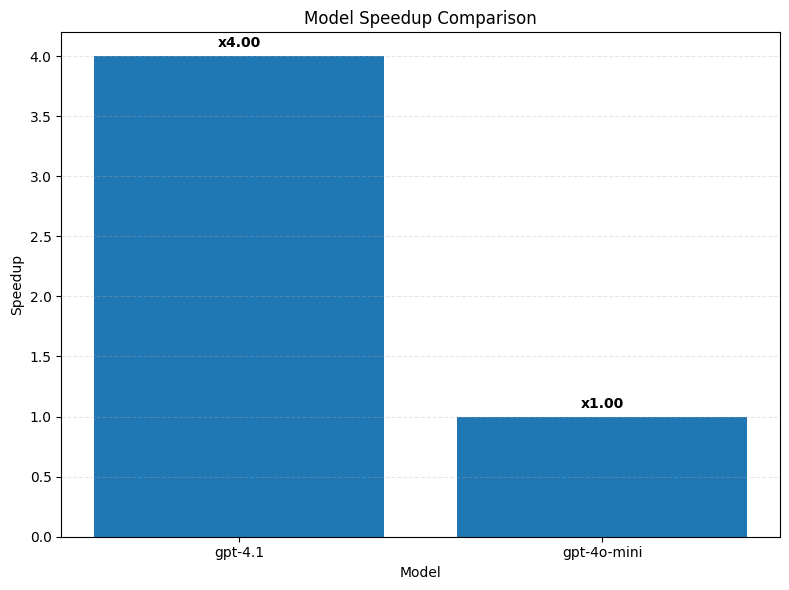

In [3]:
# Create bar plot from DataFrame
plt.figure(figsize=(8, 6))
plt.bar(df['model'], df['speedup'])
plt.ylabel('Speedup')
plt.xlabel('Model')
plt.title('Model Speedup Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(df['speedup']):
    plt.text(i, v + 0.05, f'x{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

As expected the stronger GPT-4.1 model results in a bigger speedup over baseline than a mini version!

-----
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT 